# 实战 Kaggle 比赛：图像分类 (CIFAR-10)

比赛的网址是https://www.kaggle.com/c/cifar-10

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

我们提供包含前1000个训练图像和5个随机测试图像的数据集的小规模样本

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

整理数据集

In [3]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('
print('

# 训练样本 : 1000
# 类别 : 10


将验证集从原始的训练集中拆分出来

In [4]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

在预测期间整理测试集，以方便读取

In [5]:
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

调用前面定义的函数

In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

图像增广

In [9]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

读取由原始图像组成的数据集

In [10]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

指定上面定义的所有图像增广操作

In [11]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

模型

In [12]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

训练函数

In [13]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

训练和验证模型

train loss 0.739, train acc 0.737, valid acc 0.516
1052.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


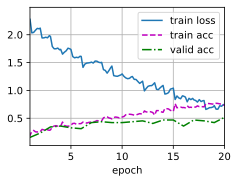

In [14]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

对测试集进行分类并提交结果

train loss 0.719, train acc 0.744
1265.8 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


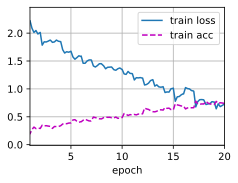

In [15]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)